In [15]:
def sinkhorn_norm(
    cost_matrix: jnp.ndarray,
    a: jnp.ndarray,
    b: jnp.ndarray,
    epsilon: float = 1e-1,
    max_iters: int = 1000,
    threshold: float = 1e-4
) -> Tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray]:
    """
    Compute Sinkhorn normalization to obtain optimal transport matrix.
    
    Args:
        cost_matrix: Matrix of costs/distances between points
        a: Source distribution (row marginals)
        b: Target distribution (column marginals)
        epsilon: Regularization parameter
        max_iters: Maximum number of iterations
        threshold: Convergence threshold
        
    Returns:
        Tuple of:
        - Transport matrix P
        - u vector (row scaling)
        - v vector (column scaling)
    """
    # Initialize scaling vectors
    u = jnp.ones_like(a)
    v = jnp.ones_like(b)
    
    # Compute kernel matrix
    K = jnp.exp(-cost_matrix / epsilon)
    
    def body_fun(state):
        u, v, i = state
        
        # Update u
        v_K = v * K
        u_new = a / (v_K.sum(axis=1) + 1e-10)
        
        # Update v
        u_K = u_new[:, None] * K
        v_new = b / (u_K.sum(axis=0) + 1e-10)
        
        return u_new, v_new, i + 1
    
    def cond_fun(state):
        u, v, i = state
        
        # Check convergence on marginals
        P = u[:, None] * K * v
        row_sums = P.sum(axis=1)
        col_sums = P.sum(axis=0)
        
        row_diff = jnp.abs(row_sums - a).max()
        col_diff = jnp.abs(col_sums - b).max()
        
        return (row_diff > threshold) & (col_diff > threshold) & (i < max_iters)
    
    # Run Sinkhorn iterations
    init_state = (u, v, 0)
    u_final, v_final, _ = jax.lax.while_loop(cond_fun, body_fun, init_state)
    
    # Compute final transport matrix
    P = u_final[:, None] * K * v_final
    
    return P, u_final, v_final

@jax.jit
def matrix_scaling(
    matrix: jnp.ndarray,
    max_iters: int = 1000,
    threshold: float = 1e-6
) -> Tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray]:
    """
    Perform matrix scaling to normalize rows and columns to sum to 1.
    
    Args:
        matrix: Input matrix to normalize
        max_iters: Maximum number of iterations
        threshold: Convergence threshold
        
    Returns:
        Tuple of:
        - Normalized matrix
        - Row scaling vector
        - Column scaling vector
    """
    n, m = matrix.shape
    ones_n = jnp.ones(n)
    ones_m = jnp.ones(m)
    
    return sinkhorn_norm(
        -jnp.log(matrix + 1e-10),  # Convert to cost matrix
        ones_n / n,                 # Uniform row distribution
        ones_m / m,                 # Uniform column distribution
        epsilon=1.0,
        max_iters=max_iters,
        threshold=threshold
    )

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def generate_GAMMA_matrix(N,h):
    GAMMA = np.zeros((N,N))

    o = np.linspace(0,1,N)

    for oi, i in enumerate(range(N)):
        for j in range(N):
            GAMMA[i,j] = np.exp(-h*np.abs(i-j))
    return GAMMA

In [23]:
scaled_matrix, row_scaling, col_scaling = matrix_scaling(generate_GAMMA_matrix(100,1))

Text(0.5, 1.0, 'Column scaling')

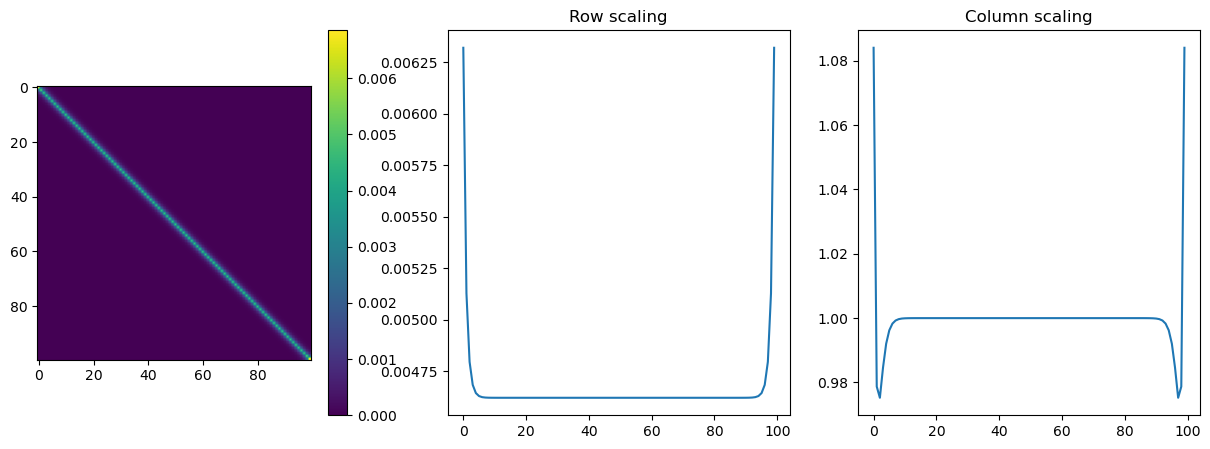

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

cax = ax[0].imshow(scaled_matrix, cmap='viridis')
fig.colorbar(cax, ax=ax[0])

ax[1].plot(row_scaling)
ax[1].set_title('Row scaling')

ax[2].plot(col_scaling)
ax[2].set_title('Column scaling')

In [29]:
from models.variable_susceptibility import initialize_states, create_contact_matrix

beta_params = [1,1]
initial_infected_prop = 1e-4


initial_state = initialize_states(beta_params, initial_infected_prop)
pops = initial_state[0] + initial_state[1] + initial_state[2]


C = create_contact_matrix(100, 0, pops)




ImportError: cannot import name 'simulate_variable_susceptibility_hom_final' from partially initialized module 'models.variable_susceptibility' (most likely due to a circular import) (c:\users\nel_t\documents\work\projects\pol_hom\src\models\variable_susceptibility.py)